In [9]:
import numpy as np
import warnings
import xarray as xr
import cartopy.crs as ccrs
import cmocean
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [2]:
ds = xr.open_dataset('../jobs/T100/data/T100.nc')
ds = ds.squeeze()

# add anomalies to datasets
for exp in ['cnt-ref','sai-ref','sai-cnt']:
    exp1,exp2 = exp.split('-')
    diff = ds.sel(exp=exp1) - ds.sel(exp=exp2)
    diff = diff.assign_coords(exp=exp)
    ds = xr.concat((ds,diff), dim='exp')

ds['dpm'] = ('month', [31,28,31,30,31,30,31,31,30,31,30,31])

In [3]:
data = ds.T100.weighted(ds.dpm).mean('month')
print('exp','[min, 0.02 pct, 0.98 pct, max]')
for exp in data.exp.data:
    print(exp, data.sel(exp=exp).quantile([0,0.02,0.98,1]).data)

exp [min, 0.02 pct, 0.98 pct, max]
ref [189.68452211 190.22321845 219.45113308 220.66756295]
cnt [192.92238339 193.35725882 219.74785122 221.4448549 ]
sai [192.28744628 192.88819577 223.02791964 225.5499684 ]
cnt-ref [-2.36454911 -2.07780921  3.16379109  3.40229605]
sai-ref [-2.94784767 -2.8529497   5.87417414  6.86120664]
sai-cnt [-1.16545226 -1.09112048  4.39356025  5.27852846]


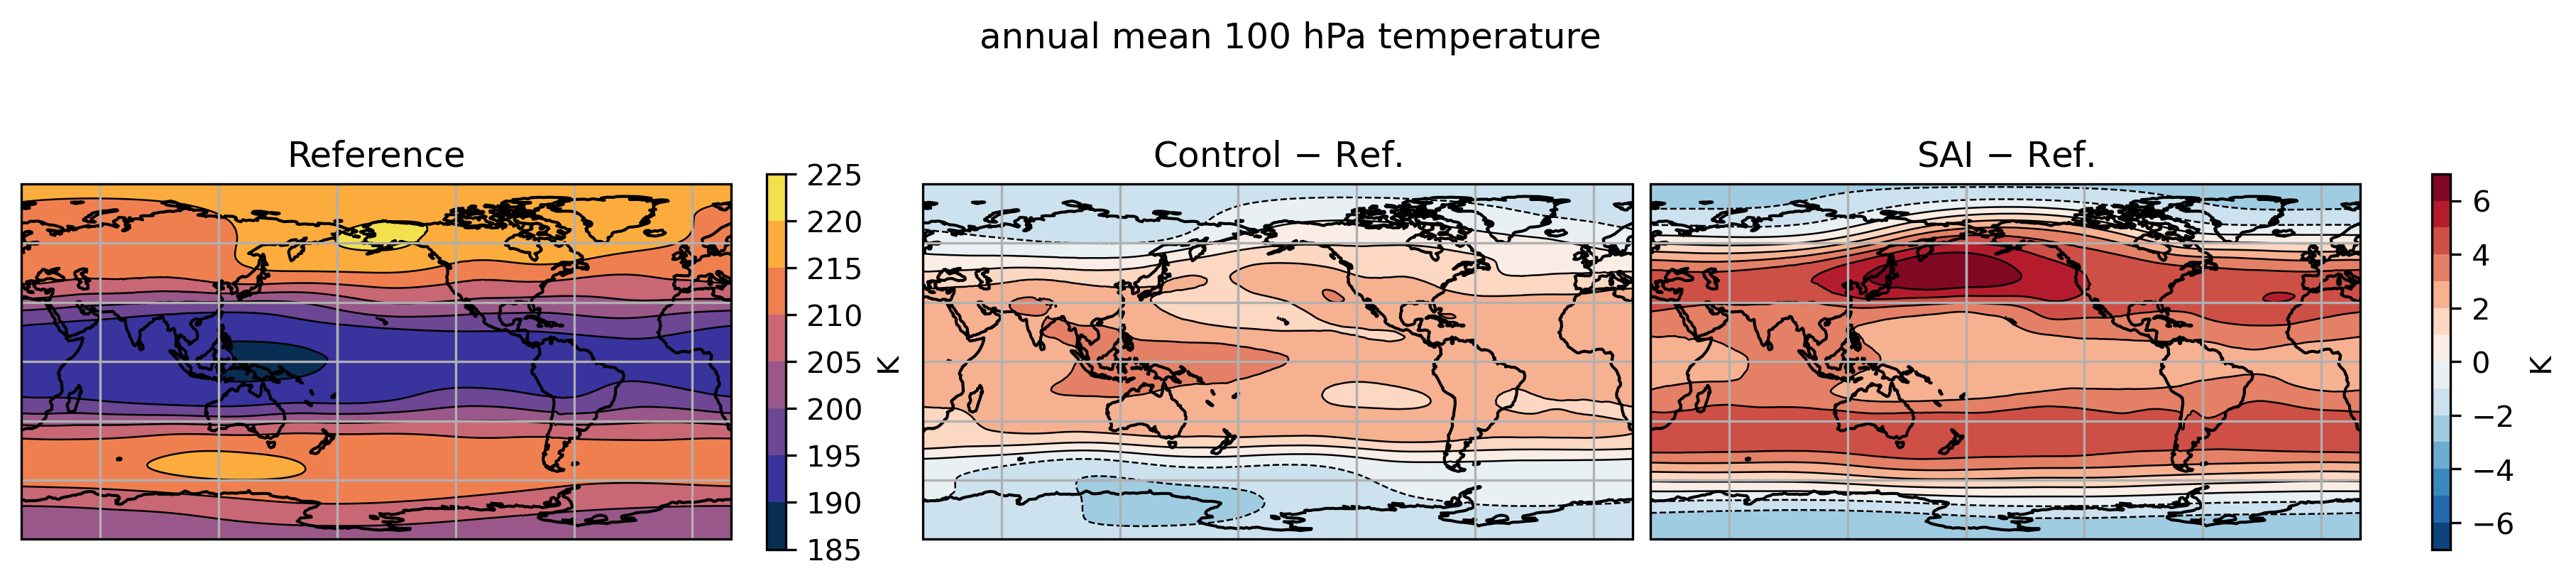

In [5]:
lats, lons = xr.broadcast(ds.lat, ds.lon)
kwargs = dict(transform=ccrs.PlateCarree(), transform_first=True)

# for data, title in zip((SST.mean('month', keep_attrs=True), SST.sel(month=10), SST.sel(month=4)), ['annual','october','april']):
data = ds.T100.weighted(ds.dpm).mean('month')

fig,axs = plt.subplots(1,3, dpi=300, figsize=(12,4), layout='constrained', subplot_kw={'projection':ccrs.PlateCarree(central_longitude=200)})

ax=axs[0]
pcm = ax.contourf(lons, lats, data.sel(exp='ref'), levels=np.arange(185,226,5), extend='neither', cmap='cmo.thermal', **kwargs)
psm = ax.contour(lons, lats, data.sel(exp='ref'), levels=np.arange(185,226,5), colors='k', linewidths=0.6, **kwargs)
#pcm.set_rasterized(True)
#psm.set_rasterized(True)
ax.contour(lons, lats, data.sel(exp='ref'), levels=[25], colors='k', linewidths=1.2, linestyles='--', **kwargs)
cb = fig.colorbar(pcm, ax=axs[0], shrink=0.45, orientation='vertical')
cb.ax.set_ylabel('K')
ax.set_title('Reference')

for ax,exp,tit in zip(axs[1:],['cnt-ref','sai-ref'],['Control $-$ Ref.','SAI $-$ Ref.']):
    pcm = ax.contourf(lons, lats, data.sel(exp=exp), levels=np.arange(-7,7.1,1), extend='neither', cmap='RdBu_r', **kwargs)
    psm = ax.contour(lons, lats, data.sel(exp=exp), levels=np.arange(-7,7.1,1), colors='k', linewidths=[0.6], **kwargs)
    #pcm.set_rasterized(True)
    ax.set_title(tit)
cb = fig.colorbar(pcm, ax=axs[1:], shrink=0.45, orientation='vertical')
cb.ax.set_ylabel('K')

for ax in axs.flatten():
    ax.gridlines()
    ax.coastlines()

fig.suptitle('annual mean 100 hPa temperature', y=0.9)
fig.savefig('../figures/T100.annualmean.pdf', bbox_inches='tight', transparent=True)


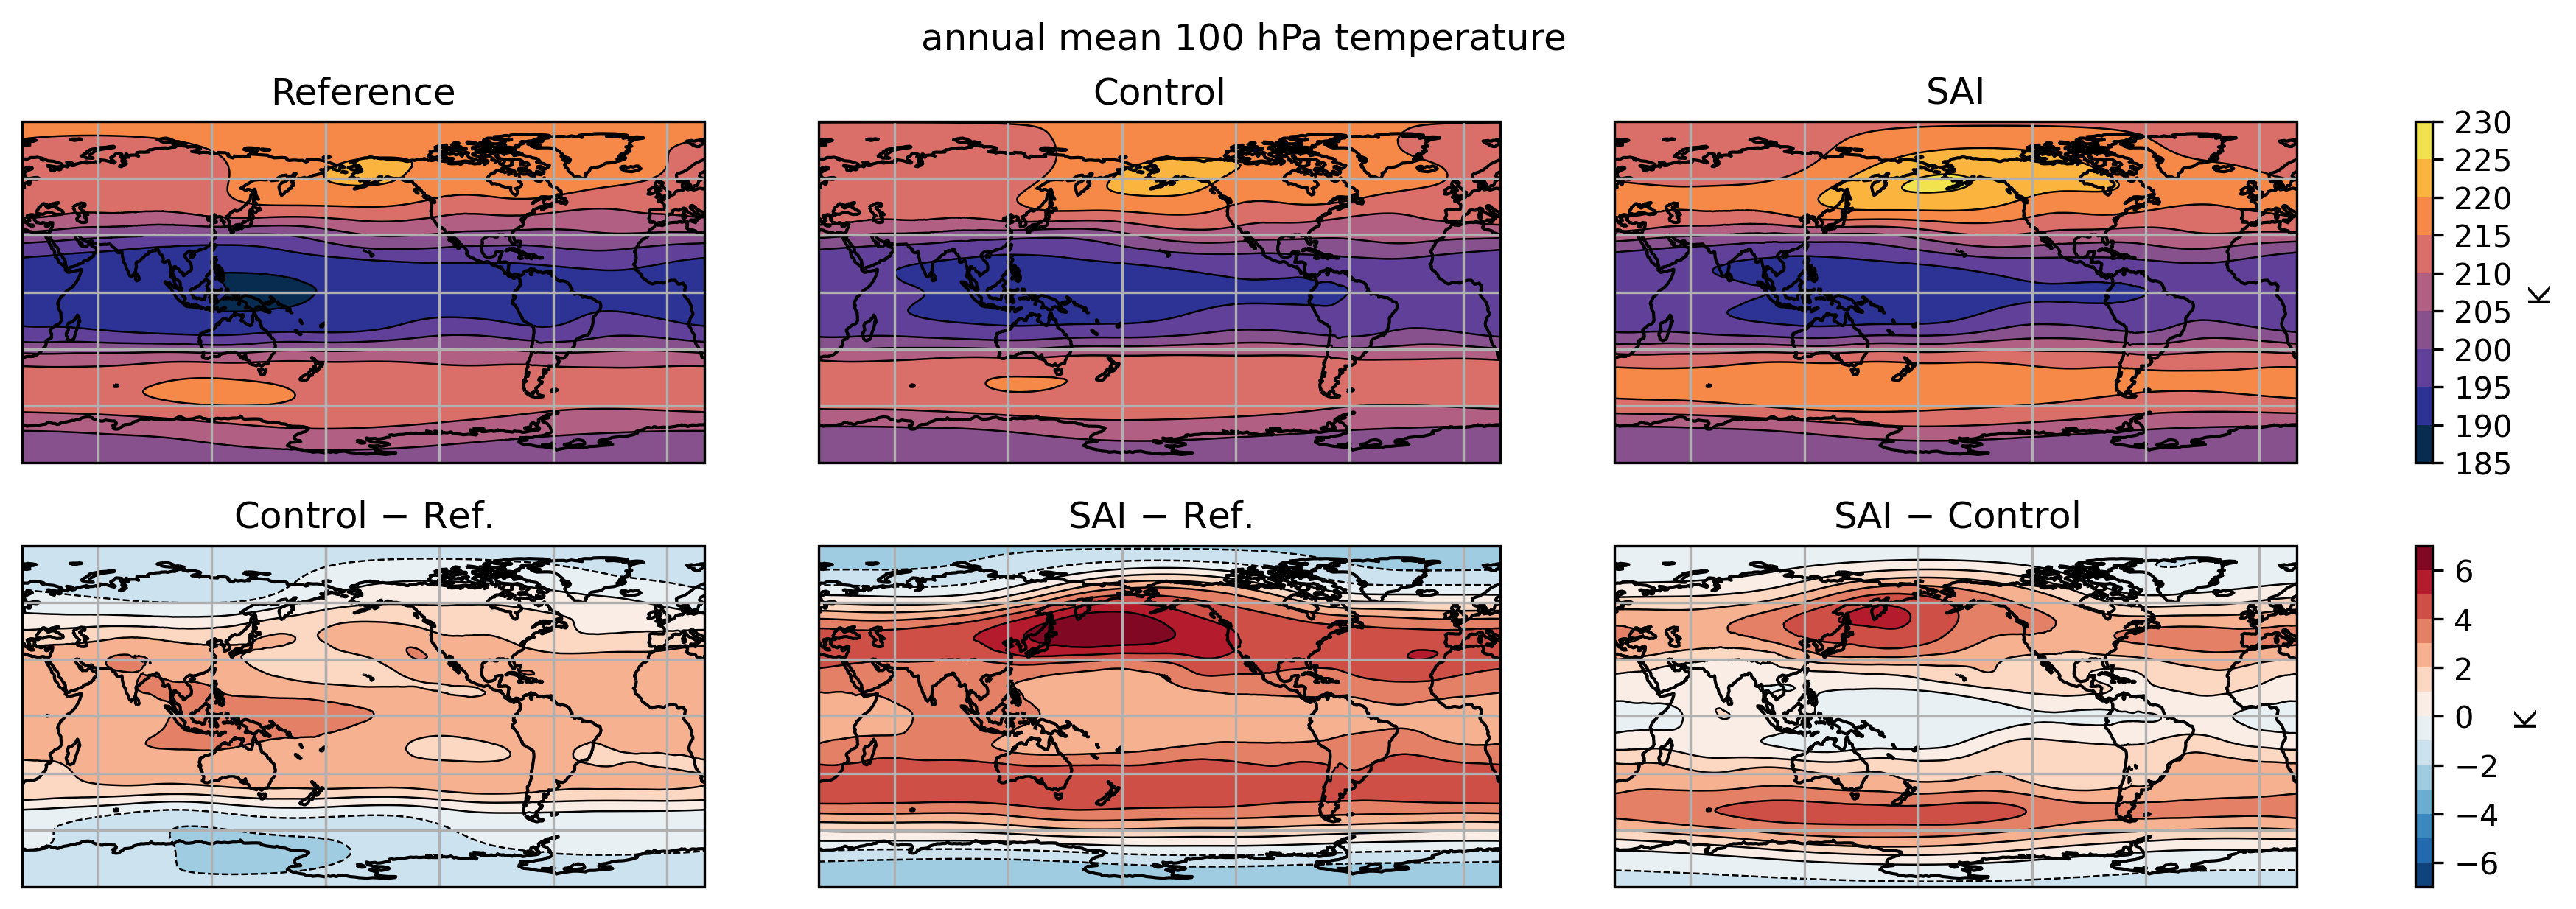

In [6]:
lats, lons = xr.broadcast(ds.lat, ds.lon)
kwargs = dict(transform=ccrs.PlateCarree(), transform_first=True)

# for data, title in zip((SST.mean('month', keep_attrs=True), SST.sel(month=10), SST.sel(month=4)), ['annual','october','april']):
data = ds.T100.weighted(ds.dpm).mean('month')

fig,axs = plt.subplots(2,3, dpi=300, figsize=(12,4), layout='constrained', subplot_kw={'projection':ccrs.PlateCarree(central_longitude=200)})

# top row: ref, cnt, sai
for ax,exp,tit in zip(axs[0,:], ['ref','cnt','sai'],['Reference','Control','SAI']):
    pcm = ax.contourf(lons, lats, data.sel(exp=exp), levels=np.arange(185,231,5), extend='neither', cmap='cmo.thermal', **kwargs)
    psm = ax.contour(lons, lats, data.sel(exp=exp), levels=pcm.levels, colors='k', linewidths=0.6, **kwargs)
    ax.set_title(tit)
cb = fig.colorbar(pcm, ax=axs[0,:], orientation='vertical')
cb.ax.set_ylabel('K')

# bottom row: differences
for ax,exp,tit in zip(axs[1,:],['cnt-ref','sai-ref','sai-cnt'],['Control $-$ Ref.','SAI $-$ Ref.','SAI $-$ Control']):
    pcm = ax.contourf(lons, lats, data.sel(exp=exp), levels=np.arange(-7,7.1,1), extend='neither', cmap='RdBu_r', **kwargs)
    psm = ax.contour(lons, lats, data.sel(exp=exp), levels=pcm.levels, colors='k', linewidths=[0.6], **kwargs)
    ax.set_title(tit)
cb = fig.colorbar(pcm, ax=axs[1,:], orientation='vertical')
cb.ax.set_ylabel('K')

for ax in axs.flatten():
    ax.gridlines()
    ax.coastlines()

fig.suptitle('annual mean 100 hPa temperature')
fig.savefig('../figures/T100.annualmean.full.pdf', bbox_inches='tight', transparent=True)

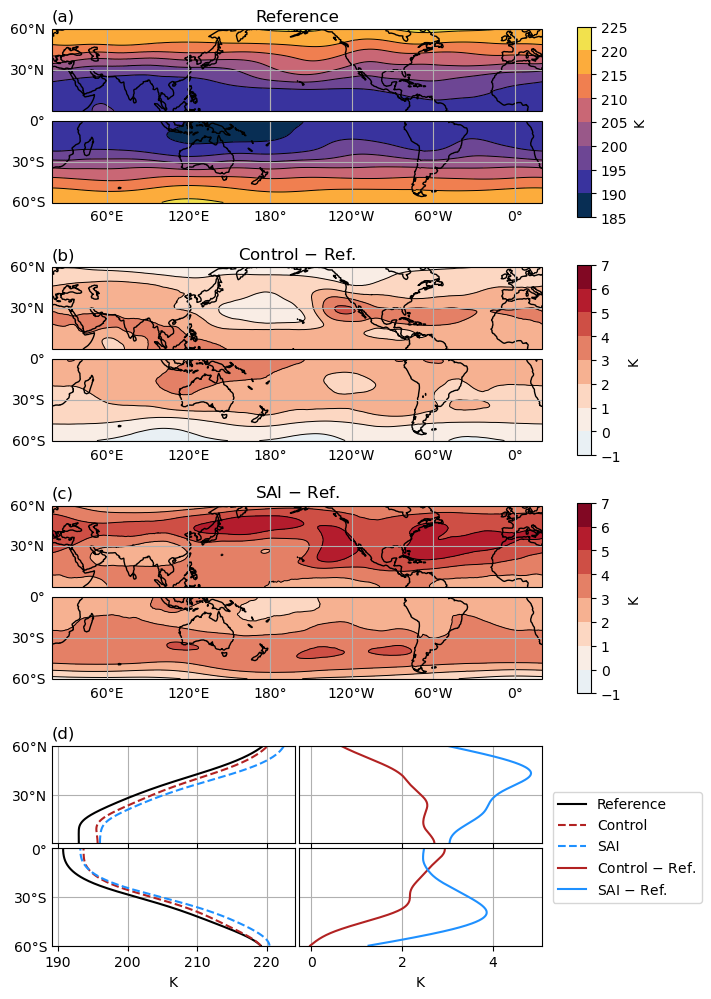

In [5]:
data_NH = ds.T100.sel(month=[6,7,8,9,10], lat=slice(0,60)).weighted(ds.dpm).mean('month')
data_SH = ds.T100.sel(month=[1,2,3,4,5], lat=slice(-60,0)).weighted(ds.dpm).mean('month')

cfdata = {
    'a': [data_NH.sel(exp='ref'), data_SH.sel(exp='ref')],
    'b': [data_NH.sel(exp='cnt-ref'), data_SH.sel(exp='cnt-ref')],
    'c': [data_NH.sel(exp='sai-ref'), data_SH.sel(exp='sai-ref')],
}

cfkwargs = {
    'a': dict(transform=ccrs.PlateCarree(), levels=np.linspace(185,225,9),extend='neither', cmap='cmo.thermal'),
    'b': dict(transform=ccrs.PlateCarree(), levels=np.linspace(-1,7,9),  extend='neither', cmap='RdBu_r', vmin=-7,),
    'c': dict(transform=ccrs.PlateCarree(), levels=np.linspace(-1,7,9),  extend='neither', cmap='RdBu_r', vmin=-7, ),
}

cbkwargs = {'a': dict(label='K'), 'b': dict(label='K'), 'c': dict(label='K')}

supy = {'a': 'Reference', 'b': 'Control $-$ Ref.', 'c': 'SAI $-$ Ref.'}

fig = plt.figure(figsize=(7, 10))
subfigs = fig.subfigures(2, 1, hspace=0.0, height_ratios=[3, 1.2])
mapfigs = subfigs[0].subfigures(3,1,hspace=0, wspace=0)
zmfig = subfigs[1]#.subfigures(1,1,wspace=0)

for i,mfig, in zip('abc', mapfigs.flatten()):
    axt, axb = mfig.subplots(2,1, sharex=True, subplot_kw={'projection':ccrs.PlateCarree(central_longitude=200)})
    cft = axt.contourf(cfdata[i][0].lon, cfdata[i][0].lat, cfdata[i][0], **cfkwargs[i])
    cfb = axb.contourf(cfdata[i][1].lon, cfdata[i][1].lat, cfdata[i][1], **cfkwargs[i])
    cst = axt.contour(cfdata[i][0].lon, cfdata[i][0].lat, cfdata[i][0], levels=cft.levels, colors='k', linewidths=0.7, transform=ccrs.PlateCarree())
    csb = axb.contour(cfdata[i][1].lon, cfdata[i][1].lat, cfdata[i][1], levels=cfb.levels, colors='k', linewidths=0.7, transform=ccrs.PlateCarree())
    for ax in (axt, axb):
        ax.coastlines()
        ax.set_title('')
        ax.set_xlabel('')
        ax.set_ylabel('')
    axt.gridlines(ylocs=[0, 30, 60], draw_labels=['left'])
    axb.gridlines(ylocs=[0,-30,-60], draw_labels=['left','bottom'])
    axt.set_extent((20,380,0,60.0001), crs=ccrs.PlateCarree())
    axb.set_extent((20,380,-60.001,0.001), crs=ccrs.PlateCarree())
    mfig.subplots_adjust(left=0.125, right=0.825, top=0.9, bottom=0.15, hspace=0.05)
    cbtax = mfig.add_axes((0.875,0.1,0.02,0.8))
    mfig.colorbar(cft, cax=cbtax, **cbkwargs[i])
    axt.set_title(f'({i})', loc='left')
    axt.set_title(supy[i])

axs = zmfig.subplots(2,2, sharey='row', sharex='col')
zmfig.subplots_adjust(left=0.125, right=0.825, top=0.9, bottom=0.2, wspace=0.05/3)
for ax in axs[0,:]:
    ax.set_ylim([0,60])
    ax.yaxis.set_tick_params(length=0)
for ax in axs[1,:]:
    ax.set_ylim([-60,0])
    ax.yaxis.set_tick_params(length=0)
axs[0,0].set_yticks([30,60], labels=['30°N','60°N'])
axs[1,0].set_yticks([-60,-30,0], labels=['60°S','30°S','0°'])

zmfig.axes[0].set_title('(d)', loc='left')
data_NH.sel(exp='ref').mean('lon').plot(ax=zmfig.axes[0], y='lat', c='k', label='Reference')
data_NH.sel(exp='cnt').mean('lon').plot(ax=zmfig.axes[0], y='lat', c='firebrick', ls='--', label='Control')
data_NH.sel(exp='sai').mean('lon').plot(ax=zmfig.axes[0], y='lat', c='dodgerblue', ls='--', label='SAI')

(data_NH.sel(exp='cnt-ref').mean('lon')).plot(ax=zmfig.axes[1], y='lat', c='firebrick', label='Control $-$ Ref.')
(data_NH.sel(exp='sai-ref').mean('lon')).plot(ax=zmfig.axes[1], y='lat', c='dodgerblue', label='SAI $-$ Ref.')

data_SH.sel(exp='ref').mean('lon').plot(ax=zmfig.axes[2], y='lat', c='k', label='Reference')
data_SH.sel(exp='cnt').mean('lon').plot(ax=zmfig.axes[2], y='lat', c='firebrick', ls='--', label='Control')
data_SH.sel(exp='sai').mean('lon').plot(ax=zmfig.axes[2], y='lat', c='dodgerblue', ls='--', label='SAI')

(data_SH.sel(exp='cnt-ref').mean('lon')).plot(ax=zmfig.axes[3], y='lat', c='firebrick', label='Control $-$ Ref.')
(data_SH.sel(exp='sai-ref').mean('lon')).plot(ax=zmfig.axes[3], y='lat', c='dodgerblue', label='SAI $-$ Ref.')

han1, lab1 = zmfig.axes[0].get_legend_handles_labels()
han2, lab2 = zmfig.axes[1].get_legend_handles_labels()
zmfig.legend(han1+han2, lab1+lab2, loc=(0.84,0.35))

zmfig.axes[0].set_xlabel('')
zmfig.axes[1].set_xlabel('')
zmfig.axes[2].set_xlabel('K')
zmfig.axes[3].set_xlabel('K')

for ax in zmfig.axes:
    ax.yaxis.set_tick_params(length=0)
    ax.set_title('')
    ax.set_ylabel('')
    ax.grid()

fig.savefig('../figures/T100.TCseason.pdf', transparent=True, bbox_inches='tight')

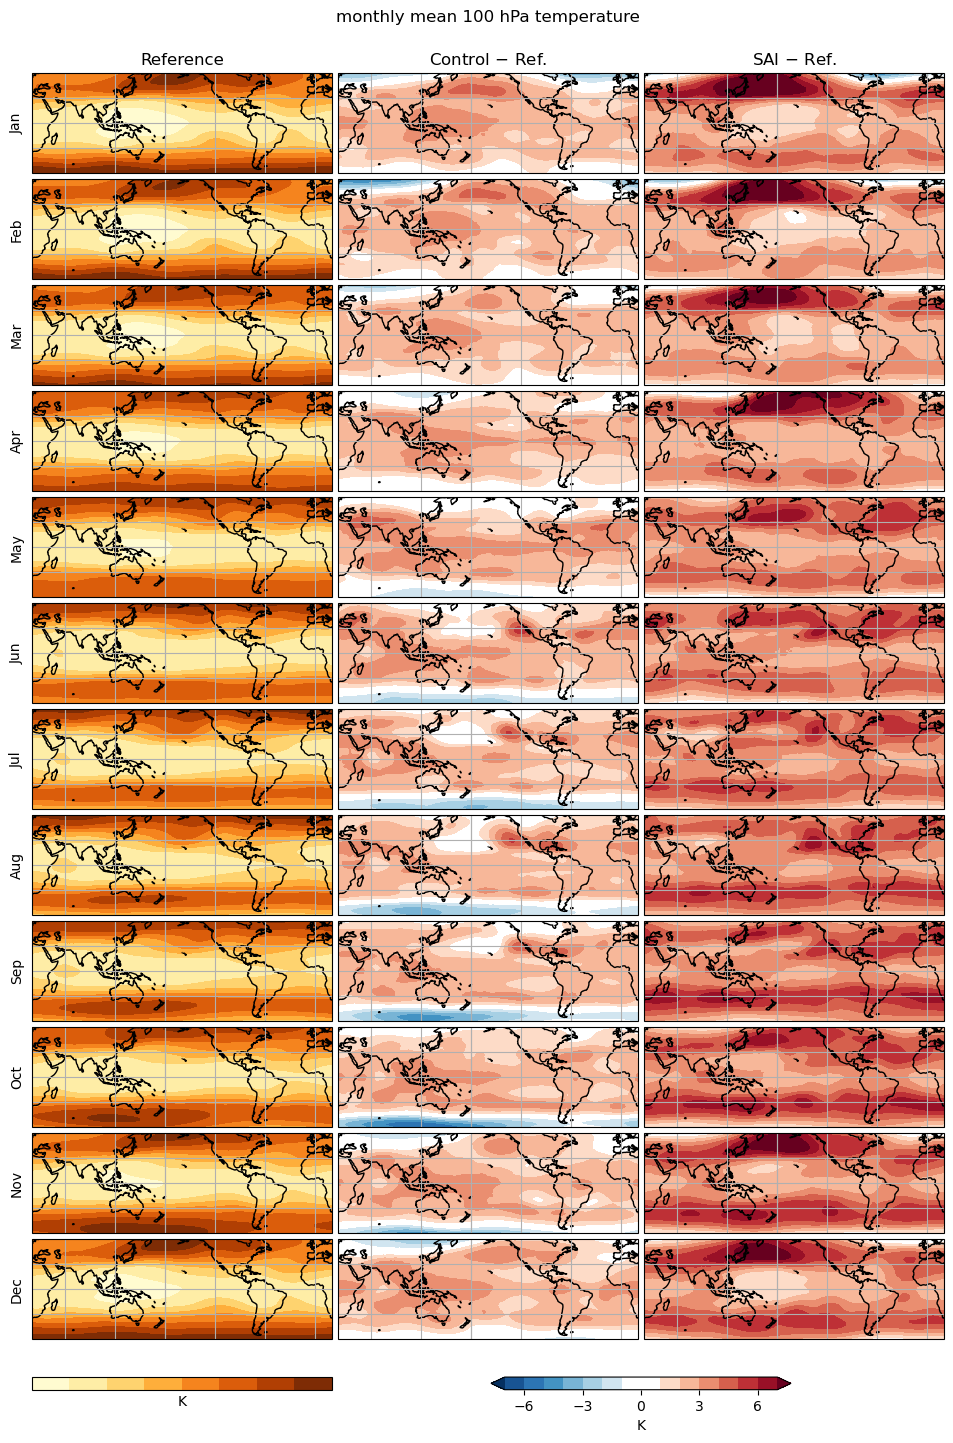

In [12]:
data = ds.T100.sel(lat=slice(-60,60))

colors = plt.get_cmap('RdBu_r')(np.linspace(0,1,16))
colors[[7,8]] = [[1,1,1,1],[1,1,1,1]]
newcmap = mcolors.ListedColormap(colors[1:-1])
newcmap.set_over(colors[-1])
newcmap.set_under(colors[0])

fig, axs = plt.subplots(12, 3, figsize=(9.12,12.66), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=200)})

for m,mon in enumerate(data.month):
    for i,exp in enumerate(['ref','cnt-ref','sai-ref']):
        datai = data.sel(exp=exp, month=mon)
        if i > 0:
            cf = axs[m,i].contourf(datai.lon, datai.lat, datai, 
                transform=ccrs.PlateCarree(), levels=range(-7,8,1), cmap=newcmap, extend='both')
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                cf.set_rasterized(True)
        else:
            cfr = axs[m,i].contourf(datai.lon, datai.lat, datai, 
                transform=ccrs.PlateCarree(), levels=range(185,226,5), cmap='YlOrBr', extend='neither')
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                cfr.set_rasterized(True)
        cs = axs[m,i].contour(datai.lon, datai.lat, datai, transform=ccrs.PlateCarree(), levels=[12.5,20], colors='k', linewidths=1, linestyles=['--','-'])
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            cs.set_rasterized(True)
        cl = axs[m,i].coastlines()
        gl = axs[m,i].gridlines(ylocs=range(-60,61,30), xlocs=range(-180,181,60), crs=ccrs.PlateCarree())
        axs[m,i].set_extent((20,380,-60,60), crs=ccrs.PlateCarree())

for e,exp in enumerate(['ref','cnt-ref','sai-ref']):
    axs[0,e].set_title(['Reference','Control $-$ Ref.','SAI $-$ Ref.'][e])

fig.subplots_adjust(bottom=0, top=1, left=0, right=1,
                    wspace=0.02, hspace=0.06)
cbr_ax = fig.add_axes([0, -0.04, 3/9.12, 0.01])
cb_ax = fig.add_axes([4.59/9.12, -0.04, 3/9.12, 0.01])
cbr = fig.colorbar(cfr, cax=cbr_ax, ticks=range(0,41,10), orientation='horizontal', label='K')
cb = fig.colorbar(cf, cax=cb_ax, ticks=range(-6,7,3), orientation='horizontal', label='K')
cbr_ax.axvline(12.5, c='k', lw=1, ls='--')
cbr_ax.axvline(20, c='k', lw=1)

for m,ax in enumerate(axs[:,0]):
    bbox = ax.get_position()
    fig.text(bbox.x0-0.05*(bbox.x1-bbox.x0),(bbox.y0+bbox.y1)/2,['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'][m], ha='center', va='center', rotation=90)

fig.suptitle('monthly mean 100 hPa temperature', y=1.05)
fig.savefig('../figures/T100.monmean.pdf', dpi=120, transparent=True, bbox_inches='tight')

In [ ]:
# Final code for TCs-under-SAI/analysis/jobs/T100/T100.py

import os
import datetime
import flox 
import xarray as xr
from load_SAIdata import Cases
import physics
import interpolate

tslices = {  # analysis periods, inclusive
    'ref': slice('2003','2007'), 
    'cnt': slice('2093','2097'), 
    'sai': slice('2093','2097')
}

def array_job_id_to_case(i):
    """generate case tag for SLURM array job id"""
    return [case for case in Cases.cases if 'hres.' in case][int(i)]


def center_timestamps(ds):
    """center timestamps in their interval given by time_bnds"""
    # only compute the centered time from time_bnds on the first step,
    # as computing it on all steps is quite slow
    tbounds = ds[ds.time.bounds]
    if 'nbnd' in tbounds.dims:
        bnd_dim = 'nbnd'
    elif 'd2' in tbounds.dims:
        bnd_dim = 'd2'
    else:
        raise NotImplementedError(f'Bound dimension unknown. {tbounds.dims=}')
    citime = tbounds[0].mean(bnd_dim).compute() # centered initial time
    dsec = (citime - ds.time[0]).dt.total_seconds().item()
    dtshift = datetime.timedelta(seconds=dsec)
    ds['time'] = ds.time + dtshift
    return ds


def get_timestep(ds):
    """Get timestep in days"""
    dt = (ds.time[1] - ds.time[0]).dt.total_seconds().item()
    return dt/86400


def open_ds_mon_atm(exp, ens, center_time=True, **kwargs):
    """open monthly CAM dataset for one ensemble member"""
    ds = (
        Cases(f'hres.{exp}.{ens}')
        .select('atm','h0')
        .open_mfdataset(**kwargs)
        #.assign_coords(exp=exp, ens=int(ens))
    )

    if center_time:
        ds = center_timestamps(ds)

    return ds


def main():
    arrjobid = os.environ['SLURM_ARRAY_TASK_ID']
    tag = array_job_id_to_case(arrjobid)
    print(f'{tag=}')
    os.makedirs('./data', exist_ok=True)
    outname = f'./data/T100.{tag}.nc'

    # read
    _,exp,ens = tag.split('.')
    ds = open_ds_mon_atm(exp, ens, chunks={})
    ds = ds.sel(time=tslices[exp])

    # interpolate temperature to 100 hPa
    P = interpolate.pressure_from_hybrid(ds)
    Ti = interpolate.interpolate(ds.T, P,  [10000], 'lev')
    Ti = Ti.rename('T100')

    # take interannual mean 
    Timean = Ti.groupby('time.month').mean()
    out = Timean.to_dataset()

    # write
    print(f'writing to {outname}')
    out.to_netcdf(outname)
    return


# if __name__ == '__main__':
#     main()